## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help in OH if you're stuck.

### Reminder

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), or use all the available data. 


In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (97.5 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import math
import itertools

In [3]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [4]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  95.1M      0  0:00:05  0:00:05 --:--:-- 98.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  45.5M      0 --:--:-- --:--:-- --:--:-- 45.3M


In [5]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

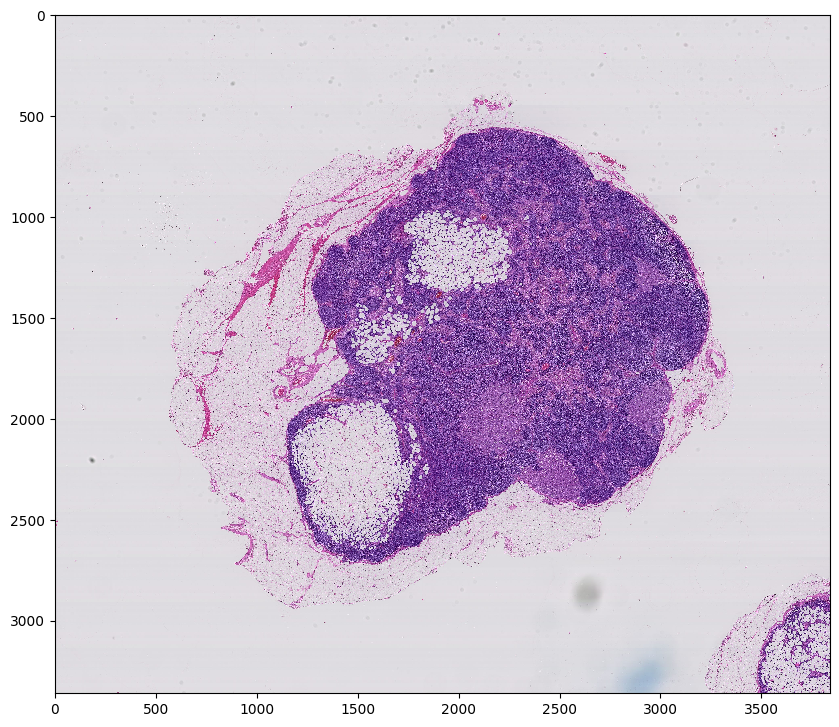

In [7]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide.level_dimensions[4][0], 
                         height=slide.level_dimensions[4][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

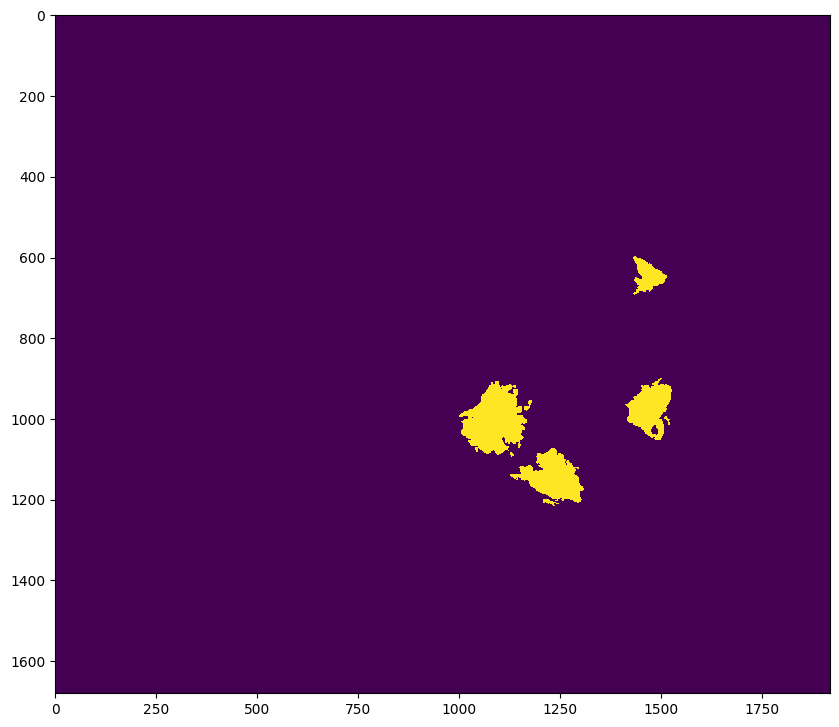

In [8]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

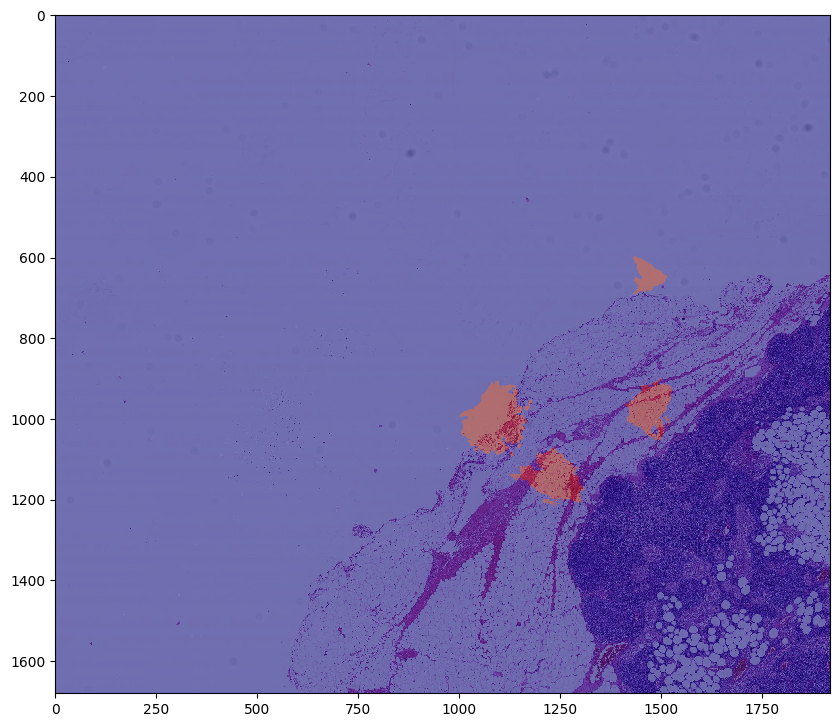

In [9]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

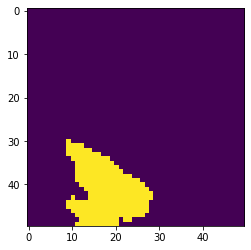

In [10]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

3451212 tissue_pixels pixels (26.7 percent of the image)


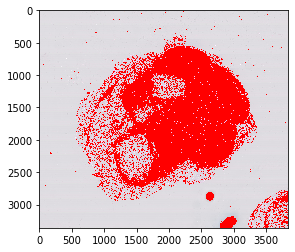

In [11]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = list(find_tissue_pixels(slide_image))
# percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
# modified
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

# My Code

Global vars

In [0]:
# DenseNet121 default 224
# MobileNetV2 default 224
# Inception V3 default 299

WIDTH = 224
HEIGHT = 224

# Helper functions


In [0]:
# this is in some sense an unnecessary function because it does the same thing as read_slide, but takes as argument the coordinates of the central pixel
# also normalizes before returning 
def generate_img_patch_and_label(slide, tumor_mask, level, main_level, center, width=WIDTH, height=HEIGHT, grey_check=False):
  x = center[0] * slide.level_downsamples[main_level] / slide.level_downsamples[level]
  y = center[1] * slide.level_downsamples[main_level] / slide.level_downsamples[level]
  x_diff = int(width/2)
  y_diff = int(height/2)

  x_new = x - x_diff
  y_new = y - y_diff

  assert 0 <= x_new <= slide.level_dimensions[level][0] - width
  assert 0 <= y_new <= slide.level_dimensions[level][1] - height

  img = read_slide(slide=slide, 
                   x=int(x_new * slide.level_downsamples[level]), 
                   y=int(y_new * slide.level_downsamples[level]), 
                   level=level, 
                   width=width, 
                   height=height)
  
  if grey_check:
    intensity = .8
    area = .8
    im_gray = rgb2gray(img)
    indices = np.where(im_gray <= intensity)
    tissue_locations = list(zip(indices[0], indices[1]))
    tissue_percent = len(tissue_locations) / (im_gray.shape[0] * im_gray.shape[1])

    # if less than 95% of the image pixels are tissue pixels
    if tissue_percent <= area: 
      return 1
    else:
      return 0

  
  mask = read_slide(slide=tumor_mask, 
                   x=int(x_new * slide.level_downsamples[level]), 
                   y=int(y_new * slide.level_downsamples[level]), 
                   level=level, 
                   width=width, 
                   height=height)
  
  label = 0
  if mask.sum() > 0:
    label = 1

  return img / 255, label

In [0]:
# so this function runs the different zoom level patches centered at x,y through the model and returns the contacenated activations
def get_activations(x, y, slide, tumor_mask, levels, model):
  label = 0
  activations = []
  for level in level_list:
    print('level:', level)
    # get patch and label at the current level
    cur_img, cur_label = generate_img_patch_and_label(slide=slide, tumor_mask=tumor_mask, level=level, main_level=main_level, center=(x,y))
    if cur_label == 1:
      label = 1
    # TODO
    # send through the pretrained network and get activations
    cur_activation = model(tf.expand_dims(cur_img, axis=0))
    cur_activation = tf.reshape(cur_activation[0], [-1])
    activations.extend(cur_activation)

  # concat activations
  # return concatenated activations
  return activations, label

# Define the pretrained model

In [15]:
# image_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT, 3))
image_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(WIDTH, HEIGHT, 3), alpha=1.0, include_top=False, weights='imagenet')
# image_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT, 3))
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

9412608/9406464 [==============================] - 1s 0us/step


In [0]:
# image_model.summary()

# Creating the training and validation data

Connect to drive

In [17]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
drive_path_raw = '/gdrive/My Drive/ADL_project/data_raw'
drive_path_train_healthy = '/gdrive/My Drive/ADL_project/data_train/healthy'
drive_path_train_tumor = '/gdrive/My Drive/ADL_project/data_train/tumor'
drive_path_val_healthy = '/gdrive/My Drive/ADL_project/data_val/healthy'
drive_path_val_tumor = '/gdrive/My Drive/ADL_project/data_val/tumor'

In [0]:
slide_list_train = [slide_path]
slide_list_val = []
level_list = [2,4,6]
main_level = 4

In [0]:
def write_activations_on_disk(slide_list, drive_path_raw, drive_path_healthy, drive_path_tumor, x_from=None, y_from=None, x_to=None, y_to=None):
  # go over each slide
  for slide_path in slide_list:
    slide = open_slide(os.path.join(drive_path_raw, slide_path))
    # go over each pixel
    # start from int(width/2), int(height/2) and go up to max[0] - ceil(width/2), max[1] - ceil(width/2)
    if x_from is None:
      x_from = math.floor(WIDTH/2)
    if x_to is None:
      x_to = slide.level_dimensions[main_level][0] - math.ceil(WIDTH/2)
    if y_from is None:
      y_from = math.floor(HEIGHT/2)
    if y_to is None:
      y_to = slide.level_dimensions[main_level][1] - math.ceil(HEIGHT/2)

    # print(x_to, y_to)

    i = 0
    # for each pixel at x,y
    for x, y in itertools.product(range(x_from, x_to+1), range(y_from, y_to+1)):
      file_name = slide_path[:-4] + '_' + str(x) + '_' + str(y) + '_activation.jpg'
      i += 1
      if i % 500 == 0:
        print(x,y)
      # check if gray
      # TODO tumor mask add input
      if generate_img_patch_and_label(slide=slide, tumor_mask=tumor_mask, level=main_level, main_level=main_level, center=(x,y), grey_check=True):
        continue
      print(x,y)      
      # TODO chekc if already done, skip
      if (file_name + '.npy' in os.listdir(drive_path_healthy)) or (file_name + '.npy' in os.listdir(drive_path_tumor)):
        continue
      activations, label = get_activations(x=x, y=y, slide=slide, tumor_mask=tumor_mask, levels=level_list, model=image_features_extract_model)
      # print(activations)
      # print(label)

      # TODO
      
      if label == 0:
        # write it in train/healthy
        print('writing in', drive_path_healthy)
        np.save(os.path.join(drive_path_healthy, file_name), np.array(activations)) 
      else:
        # write it in train/tumor
        print('writing in', drive_path_tumor)
        np.save(os.path.join(drive_path_tumor, file_name), np.array(activations))      
    print('DONE')

In [0]:
# train
# write_activations_on_disk(slide_list_train, drive_path_raw, drive_path_train_healthy, drive_path_train_tumor, x_from=2100, y_from=2000, x_to=2500, y_to=2400)

# Train the model on activations

need to create two dataframes with absolute paths and labels then join them

In [0]:
healthies = [os.path.join(drive_path_train_healthy, path) for path in os.listdir(drive_path_train_healthy)]
tumors = [os.path.join(drive_path_train_tumor, path) for path in os.listdir(drive_path_train_tumor)]

In [0]:
import pandas as pd

In [0]:
df_0 = pd.DataFrame(healthies, 
               columns =['path']) 
df_0['label'] = 0

df_1 = pd.DataFrame(tumors, 
               columns =['path']) 
df_1['label'] = 1

df_all = pd.concat([df_0, df_1], axis=0, ignore_index=True, copy=True)

In [0]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_all, test_size=0.2)

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [0]:
def load_np(activation_path, label):
  activations = np.load(activation_path)
  return activations, label

In [0]:
def create_dataset(images, labels):
  dataset = tf.data.Dataset.from_tensor_slices((images, labels))
  # TODO jbgordon@: rewrite this to be clearer
  # Load the cached activations off disk
  dataset = dataset.map(lambda x, y: tf.numpy_function(
      load_np, [x, y], [tf.float32, tf.int32]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [0]:
train_ds = create_dataset(df_train['path'].to_list(), df_train['label'].to_list())
val_ds = create_dataset(df_val['path'].to_list(), df_val['label'].to_list())

Sanity check

In [118]:
my_iterator = iter(train_ds)
activations_batch, labels_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape)

(32, 188160) (32,)


In [0]:
# tf.expand_dims(labels_batch, axis=1)

The model

In [0]:
model_classify = tf.keras.models.Sequential()
model_classify.add(tf.keras.layers.Dense(1, input_shape=(188160,), activation='sigmoid'))

In [0]:
model_classify.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [122]:
model_classify.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 188161    
Total params: 188,161
Trainable params: 188,161
Non-trainable params: 0
_________________________________________________________________


# Training

In [0]:
# You should not need to modify this.
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model_classify.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')#, from_logits=True)
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [128]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10

# Training loop
for epoch in range(epochs):

  # Train for one epoch
  for activation_batch, label_batch in train_ds:
    result = model_classify.train_on_batch(x=activation_batch, y=label_batch)    

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

Epoch 0, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 1, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 2, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 3, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 4, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 5, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 6, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 7, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 8, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00
Epoch 9, Loss: 0.00, Accuracy: 100.00, Val Loss 0.00, Val Accuracy 100.00


# Evaluate on a test slide

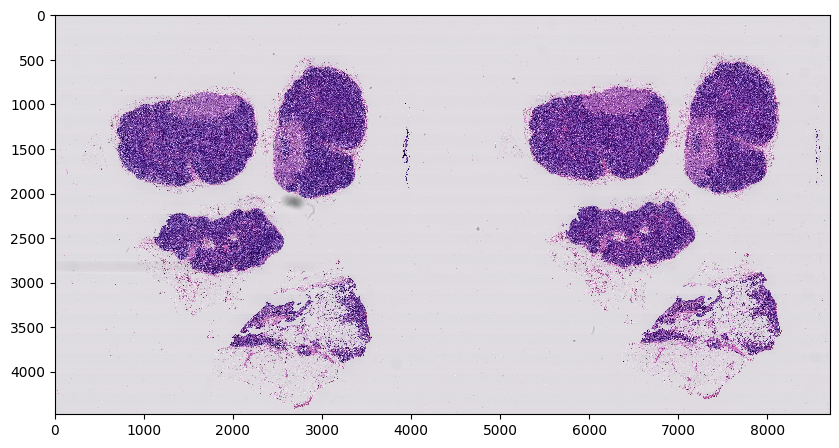

In [154]:
slide_image = read_slide(test_slide,
                         x=0, 
                         y=0, 
                         level=8, 
                         width=test_slide.level_dimensions[8][0], 
                         height=test_slide.level_dimensions[8][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [0]:
def is_grey(img, intensity=.8, area=.8):
  im_gray = rgb2gray(img)
  indices = np.where(im_gray <= intensity)
  tissue_locations = list(zip(indices[0], indices[1]))
  tissue_percent = len(tissue_locations) / (im_gray.shape[0] * im_gray.shape[1])

  # if less than 80% of the image pixels are tissue pixels
  if tissue_percent <= area: 
    return 1

In [0]:
# this is in some sense an unnecessary function because it does the same thing as read_slide, but takes as argument the coordinates of the central pixel
# also normalizes before returning 
def generate_img_patch_test(slide, level, main_level, center, width=WIDTH, height=HEIGHT):
  x = center[0] * slide.level_downsamples[main_level] / slide.level_downsamples[level]
  y = center[1] * slide.level_downsamples[main_level] / slide.level_downsamples[level]
  x_diff = int(width/2)
  y_diff = int(height/2)

  x_new = x - x_diff
  y_new = y - y_diff

  assert 0 <= x_new <= slide.level_dimensions[level][0] - width
  assert 0 <= y_new <= slide.level_dimensions[level][1] - height

  img = read_slide(slide=slide, 
                   x=int(x_new * slide.level_downsamples[level]), 
                   y=int(y_new * slide.level_downsamples[level]), 
                   level=level, 
                   width=width, 
                   height=height)

  return img / 255

In [0]:
# so this function runs the different zoom level patches centered at x,y through the model and returns the contacenated activations
def get_activations_test(x, y, slide, levels, main_level, model):
  activations = []
  for level in level_list:
    print('level:', level)
    # get patch at the current level
    cur_img = generate_img_patch_test(slide=slide, level=level, main_level=main_level, center=(x,y))

    # send through the pretrained network and get activations
    cur_activation = model(tf.expand_dims(cur_img, axis=0))
    cur_activation = tf.reshape(cur_activation[0], [-1])
    activations.extend(cur_activation)

  # concat activations
  # return concatenated activations
  return activations

In [0]:
test_slide = open_slide(os.path.join(drive_path_raw, 'tumor_101.tif'))
test_mask_image = np.zeros((HEIGHT, WIDTH))

In [0]:
main_level_test = 9

In [0]:
x_from = math.floor(WIDTH/2)
x_to = test_slide.level_dimensions[6][0] - math.ceil(WIDTH/2)
y_from = math.floor(HEIGHT/2)
y_to = test_slide.level_dimensions[6][1] - math.ceil(HEIGHT/2)

In [0]:
x_from = int(x_from * test_slide.level_downsamples[6] / test_slide.level_downsamples[main_level_test])
x_to = int(x_to * test_slide.level_downsamples[6] / test_slide.level_downsamples[main_level_test])
y_from = int(y_from * test_slide.level_downsamples[6] / test_slide.level_downsamples[main_level_test])
y_to = int(y_to * test_slide.level_downsamples[6] / test_slide.level_downsamples[main_level_test])

In [0]:
total_pixels = (x_to - x_from + 1) * (y_to - y_from + 1) 

In [326]:
total_pixels

27685

In [0]:
input_size = 188160

In [0]:
# slide across patches
cnt = 0
for x in range(x_from, x_to+1):
  for y in range(y_from, y_to+1):
    cnt += 1
    print(cnt, '/', total_pixels, sep='')

    img = generate_img_patch_test(slide=test_slide, level=6, main_level=main_level_test, center=(x,y), width=WIDTH, height=HEIGHT)
    if is_grey(img, intensity=.8, area=.5):
      continue
    
    activations = get_activations_test(x, y, slide=test_slide, levels=level_list, main_level=main_level_test, model=image_features_extract_model)
    activations += [0] * (input_size - len(activations))
    out = model_classify.predict(tf.expand_dims(activations, axis=0)).item()
    if math.floor(out) == 1:
       test_mask_image[x,y] = 1

1/27685
2/27685
3/27685
4/27685
5/27685
6/27685
7/27685
8/27685
9/27685
10/27685
11/27685
12/27685
13/27685
14/27685
15/27685
16/27685
17/27685
18/27685
19/27685
20/27685
21/27685
22/27685
23/27685
24/27685
25/27685
26/27685
27/27685
28/27685
29/27685
30/27685
31/27685
32/27685
33/27685
34/27685
35/27685
36/27685
37/27685
38/27685
39/27685
40/27685
41/27685
42/27685
43/27685
44/27685
45/27685
46/27685
47/27685
48/27685
49/27685
50/27685
51/27685
52/27685
53/27685
54/27685
55/27685
56/27685
57/27685
58/27685
59/27685
60/27685
61/27685
62/27685
63/27685
64/27685
65/27685
66/27685
67/27685
68/27685
69/27685
70/27685
71/27685
72/27685
73/27685
74/27685
75/27685
76/27685
77/27685
78/27685
79/27685
80/27685
81/27685
82/27685
83/27685
84/27685
85/27685
86/27685
87/27685
88/27685
89/27685
90/27685
91/27685
92/27685
93/27685
94/27685
95/27685
96/27685
97/27685
98/27685
99/27685
100/27685
101/27685
102/27685
103/27685
104/27685
105/27685
106/27685
107/27685
108/27685
109/27685
110/27685
111/2768

In [0]:
# overlay image with prediction
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(test_mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
# overlay image with true mask
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.